In [3]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import knights_tour
from matplotlib.markers import MarkerStyle
import scipy
from scipy.optimize import curve_fit
import copy
import glob

%matplotlib widget


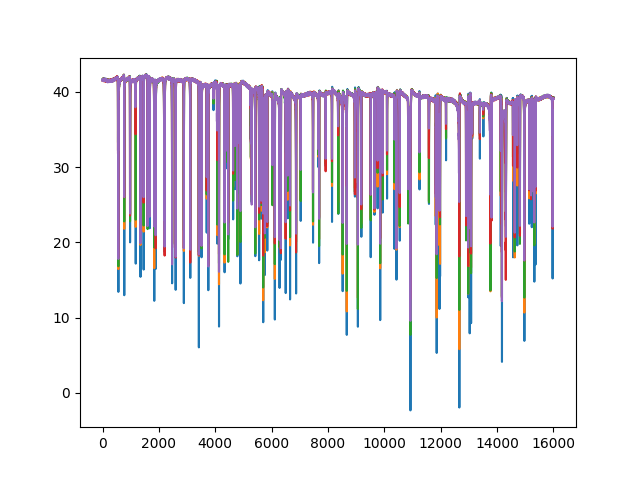

In [14]:
files = glob.glob('./Mappings/LT343chip2/*2024.npy')
darkfile = glob.glob('./Mappings/LT343chip2/*dark.npy')[0]
fig, ax = plt.subplots()
ax.plot(np.load(darkfile))
for file in files:
    s21 = np.load(file)
    ax.plot(s21)


In [ ]:
def image(f, s0):
    return 1 / (1/f - 1/s0)

def mag(f, s0):
    return - f / (s0 - f)

def object(M, f):
    return - f / M + f

M = -1/2

M_max = - 2 / 7 

f = 500

s0 = object(M, f)
si = image(f, s0)
print(7/2, 1/M_max, s0, si)

In [ ]:
f1 = 100
f2 = 100
s01 = 0.5*f1
d = f1 + f2
si1 = image(f1, s01)
s02 = d - si1
si2 = image(f, s02)
m = mag(f1, s01) * mag(f2, s02)
print(m, si2)

In [ ]:
dF = 4e6
F_min = 5e9
F_max = 7e9
gridx = 20
gridy = 20
nr_pxl = gridx * gridy
pitchx = 150
pitchy = 150
sigma = 5.9e-3
F_design = np.linspace(F_min, F_max, nr_pxl)
idx_design = np.argsort(F_design, axis=0, kind='quicksort')
scatter = normal(0, sigma, F_design.shape)
F_meas = F_design + F_design * scatter
idx_meas = np.argsort(F_meas, axis=0, kind='quicksort')
swapped = np.nonzero(idx_design-idx_meas)

In [ ]:
fig, ax = plt.subplot_mosaic('abc', constrained_layout=True)
_ = ax['a'].scatter(np.arange(400), F_design)
_ = ax['a'].scatter(np.arange(400), F_meas)
secax = ax['a'].twinx()
_ = secax.plot(F_design - F_meas)
_ = ax['b'].hist((F_design-F_meas)/F_design)
_ = ax['c'].hist((F_meas[1:]-F_meas[:-1])*1e-6)



In [ ]:
# idx = np.array([[1, 16, 7, 26, 11, 14], [34, 25, 12, 15, 6, 27], [17, 2, 33, 8, 13, 10], [32, 35, 24, 21, 28, 5], [23, 18, 3, 30, 9, 20], [36, 31, 22, 19, 4, 29]])
idx = np.load('./LT295_400pxl_design\KID_id_board_400.npy')
coords = np.zeros((2, nr_pxl))
for i in range(nr_pxl):
    coords[:, i] = (np.argwhere(idx==i+1) - np.array([(gridx-1)/2, (gridy-1)/2])) * np.array([pitchx, pitchy])
pos = copy.copy(coords)

theta = 0 * np.pi
rot_mat = np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])
print(rot_mat)
misalign = np.array([0, 0])

fig, ax = plt.subplot_mosaic('ab', constrained_layout=True)
for i in range(nr_pxl):
    pos[:, i] = np.matmul(rot_mat, pos[:, i]) + misalign
    _ = ax['a'].scatter(coords[0, i], coords[1, i], c='b', marker='$%d$' % (idx_design[i]), edgecolors='b', linewidths=0.5)
    if i in swapped[0]:
        _ = ax['b'].scatter(pos[0, i], pos[1, i], c='r', marker='$%d$' % (idx_meas[i]), edgecolors='r', linewidths=0.5)
    else:
        _ = ax['b'].scatter(pos[0, i], pos[1, i], c='b', marker='$%d$' % (idx_meas[i]), edgecolors='b', linewidths=0.5)
# _ = ax['b'].scatter(pos[0, swapped], pos[1, swapped], c='None', marker='o', edgecolors='r', linewidths=0.5)
_ = ax['a'].axis('equal')
_ = ax['a'].axvline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['a'].axhline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['b'].axis('equal')
_ = ax['b'].axvline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['b'].axhline(0, 0, 1, color='k', linewidth=0.5)

In [ ]:
bw = 10
dx = 10
startx = -gridx * pitchx
stopx = gridx*pitchx
dy = 10
starty = -gridy * pitchy
stopy = gridy * pitchy
posx = np.arange(startx, stopx+dx, dx)
posy = np.arange(starty, stopy+dy, dy)
tstepx = np.arange(len(posx))
tstepy = np.arange(len(posy))
datax = np.zeros((nr_pxl, len(posx)))
datay = np.zeros((nr_pxl, len(posy)))

for t in tstepx:
    x = posx[t]
    kids = idx_meas[(pos[0, :] >= x-bw/2 ) & (pos[0, :] <= x+bw/2 )]
    if len(kids) != 0:
        for kid in kids:
            datax[kid, t] = 1
for i in range(nr_pxl):
    old_row = datax[i, :]
    idx_pxl = np.mean(np.nonzero(old_row))
    new_row = np.zeros((datax.shape[1]))
    new_row[int(idx_pxl)] = 1
    datax[i, :] = new_row

for t in tstepy:
    y = posy[t]
    kids = idx_meas[(pos[1, :] >= y-bw/2 ) & (pos[1, :] <= y+bw/2 )]
    if len(kids) != 0:
        for kid in kids:
            datay[kid, t] = 1
for i in range(nr_pxl):
    old_row = datay[i, :]
    idx_pxl = np.mean(np.nonzero(old_row))
    new_row = np.zeros((datax.shape[1]))
    new_row[int(idx_pxl)] = 1
    datay[i, :] = new_row


In [ ]:
meas_pos = np.zeros((2, nr_pxl))
fig, ax = plt.subplot_mosaic('abc')
for i in range(nr_pxl):
    kidx = posx[datax[i, :]==1]
    kidy = posy[datay[i, :]==1]
    meas_pos[0, i] = kidx[0]
    meas_pos[1, i] = kidy[0]
meas_pos[0, :] -= np.mean(meas_pos[0, :])
meas_pos[1, :] -= np.mean(meas_pos[1, :])
H = np.matmul(meas_pos, coords.T)
[u, s, v] = np.linalg.svd(H)
R = np.matmul(v, u.T)
theta = np.arccos(R[0, 0])
print('theta = %.2f pi' % (theta / np.pi))
rot_mat = np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])
misalign = np.array([0, 0])
overlapping = []
for i in range(nr_pxl):
    kidx = posx[datax[i, :]==1]
    kidy = posy[datay[i, :]==1]
    _ = ax['a'].scatter(coords[0, i], coords[1, i], c='b', marker='$%d$' % (idx_design[i]), edgecolors='b', linewidths=0.5)
    fit_pos = np.matmul(rot_mat, coords[:, i]) + misalign
    _ = ax['b'].scatter(pos[0, i], pos[1, i], c='b', marker='$%d$' % (idx_design[i]), edgecolors='b', linewidths=0.5)
    if np.absolute(kidx - fit_pos[0]) > pitchx/2 or np.absolute(kidy - fit_pos[1]) > pitchy/2:
        _ = ax['c'].scatter(kidx, kidy, c='r', marker='$%d$' % (i), edgecolors='r', linewidths=0.5)
        overlapping.append(i)
    else:
        _ = ax['c'].scatter(kidx, kidy, c='b', marker='$%d$' % (i), edgecolors='b', linewidths=0.5)
overlapping = np.array(overlapping)  
print('Correctly identified swapped resonators:', len(np.setdiff1d(swapped, overlapping))==0)
_ = ax['a'].axis('equal')
_ = ax['a'].axvline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['a'].axhline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['b'].axis('equal')
_ = ax['b'].axvline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['b'].axhline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['c'].axis('equal')
_ = ax['c'].axvline(0, 0, 1, color='k', linewidth=0.5)
_ = ax['c'].axhline(0, 0, 1, color='k', linewidth=0.5)

In [ ]:
theta = np.arccos(R[0, 0])
print(theta / np.pi)

In [ ]:
theta = 1 * np.pi
rot_mat = np.array([[np.cos(theta), np.sin(theta)],
                    [-np.sin(theta), np.cos(theta)]])
misalign = np.array([0, 0])


a = np.array([[0, 1, 0.5],
              [1, 0, 0.5]])
b = np.array([[0, -1, -0.5],
              [-1, 0, -0.5]])

def rotate(vector, theta):
    rot_mat = np.array([[np.cos(theta), np.sin(theta)],
                        [-np.sin(theta), np.cos(theta)]])
    return np.matmul(rot_mat, vector)

rotate(a, np.pi)

In [ ]:
H = np.matmul(a, b.T)
[u, s, v] = np.linalg.svd(H)
R = np.matmul(v, u.T)

In [ ]:
R